In [98]:
source("functions/data.R")
source("functions/process.R")
source("functions/simulations.R")

In [90]:
# Define dataframes
ETH <- get_data("ETH",params$start,params$end,params$period,52,FALSE)
XRP <- get_data("XRP",params$start,params$end,params$period,52,FALSE)
XMR <- get_data("XMR",params$start,params$end,params$period,52,FALSE)
LTC <- get_data("LTC",params$start,params$end,params$period,52,FALSE)

high <- cbind(ETH$high,XRP$high,XMR$high,LTC$high)
low <- cbind(ETH$low,XRP$low,XMR$low,LTC$low)
open <- cbind(ETH$open,XRP$open,XMR$open,LTC$open)
close <- cbind(ETH$close,XRP$close,XMR$close,LTC$close)

# Rename all the columns
colnames(high)  <- currency_vec
colnames(low) <- currency_vec
colnames(open) <- currency_vec
colnames(close) <- currency_vec
prices_vec <- list(high,low,open,close)

No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.


In [91]:
dim(ETH)

[1] 8478    7

In [8]:
# simulates contextual bandits problem
# params
# n_curren: number of currencies in proble (including cash)
# n_steps: number of timesteps in the episode
# alpha: learning rate of the action preference functions
# window_size: size of rolling window of asset prices to consider in the action preferences
# discount: discount factor of previous price changes
simulate_contextual1 <- function(n_curren,n_steps,alpha,window_size,discount){
    
    Ht <- rep(0,5) # initialize preference vector
    
    # Initialize weight vector for moving average window
    weight_vec <- c()
    for(k in 0:(window_size-1))
        weight_vec <- c(weight_vec,discount^k)
    weight_vec <- rev(weight_vec)
    
    price <- head(close,window_size+1) # initializes the price dataframe as the first 2 price vectors
    #st <- getPriceRelativeVec(price[1,],price[2,]) # get first price relative vector (first state)
    
    # history vector of price changes
    history <- getPriceRelativeVec(price[1,],price[2,])
    for(h in 2:window_size){
        history <- rbind(history,getPriceRelativeVec(price[h,],price[h+1,]))
    }
    
    # Define state st as vector of discounted previous relative changes
    st <- weight_vec %*% history
    
    prev_v <- tail(price,1) # initializes first price vector v
    
    # Define reward vecs and random action reward vectors
    Rvec <- c()
    Rvec_random <- c()
    Rvec_market <- c()
    market_average <- rep(1/5,5)
    
    # initialize matrices
    piMat <- matrix(c(1,0,0,0,0),nrow=1,byrow=T)
    hMat <- matrix(Ht,nrow=1,byrow=T)
    yMat <- matrix(rep(0,n_curren),nrow=1,byrow=T)
    
    for(i in window_size:n_steps){
        # get price dataframe of current time step
        price <- head(close,i+2)
        # get the current v
        curr_v <- tail(price,1)
        # get price change
        yt <- getPriceRelativeVec(prev_v,curr_v)
        
        # update history matrix
        history <- rbind(tail(history,window_size-1),yt)
        
        # preference vector for state s (element-wise multiplication of Ht and st)
        Ht_s <- st * Ht
        
        # Compute pivec (softmaxes for each currency)
        piVec <- c()
        for(a in 1:n_curren)
            piVec <- c(piVec,get_softmax(a,Ht_s))
        
        # get the prefered action
        action <- which.max(piVec)
        
        # get the log returns for our action (in this case our action is the softax)
        rt <- exp(getLogReturns(yt,piVec))
        Rvec <- c(Rvec,rt)
        
        # Reward for random action
        Rvec_random <- c(Rvec_random,exp(getLogReturns(yt,random_action(4))))
        
        # Reward for market average
        Rvec_market <- c(Rvec_market,exp(getLogReturns(yt,market_average)))
        
        # Update preference vector
        Ht <- get_update(rt,Rvec,Ht,action,alpha)
        
#         print(log(yt))
#         print(Ht)
#         print(piVec)
#         print("=========================================")
        
#         print(paste0("episode",i))
#         print(cat("Ht: ", Ht))
#         print(cat("Ht_s: ", Ht_s))
        # print(cat("piVec: ", piVec))
#         print(cat("rt: ", rt))
        # print("==============================")
        
        prev_v <- curr_v
        st <- weight_vec %*% history
        
        # append to matrices
        piMat <- rbind(piMat,piVec)
        hMat <- rbind(hMat,Ht)
        yMat <- rbind(yMat,yt)
            
    }
    
    return_list <- list(prod(Rvec),prod(Rvec_market),piMat,hMat,yMat,cumprod(Rvec),cumprod(Rvec_market))
    names(return_list) <- c("AgentRt","mktAve","actions","prefs","changes","AgentVec","mktVec")
    
#     print(prod(Rvec))
#     print(prod(Rvec_random))
  #  print(prod(Rvec_market))
    # return(c(prod(Rvec),prod(Rvec_market)))
    return(return_list)
    
}

In [93]:
test.run <- simulate_contextual1(5,nrow(close),0.3,10,0.8)

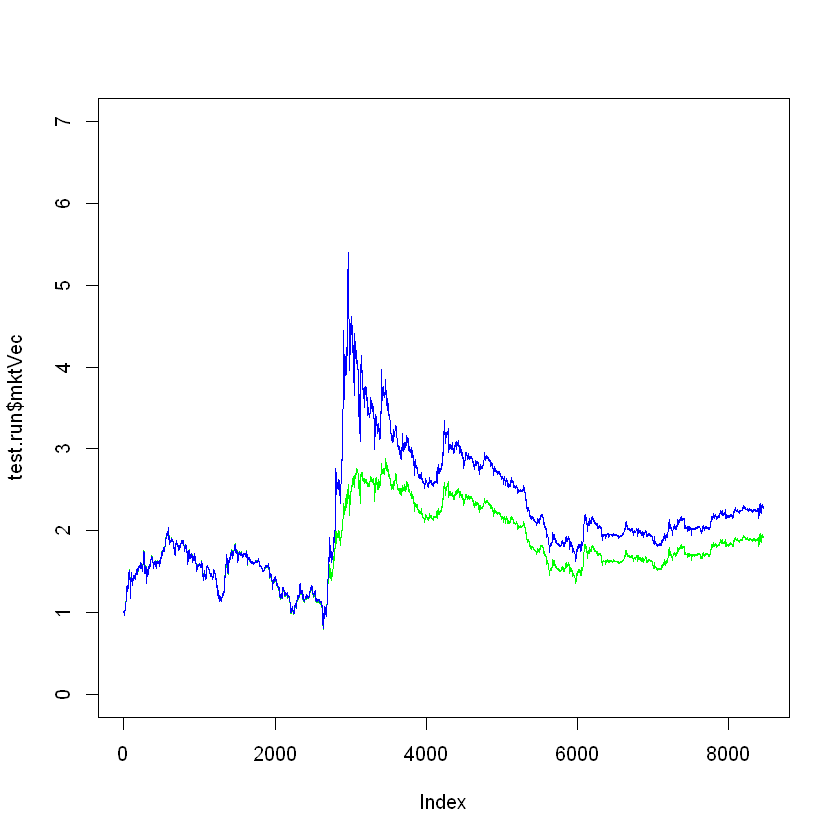

In [94]:
# Plot cummulative returns for agent and mkt
plot(test.run$mktVec,type="l",col="green",ylim=c(0,7))
lines(test.run$AgentVec,type="l",col="blue")

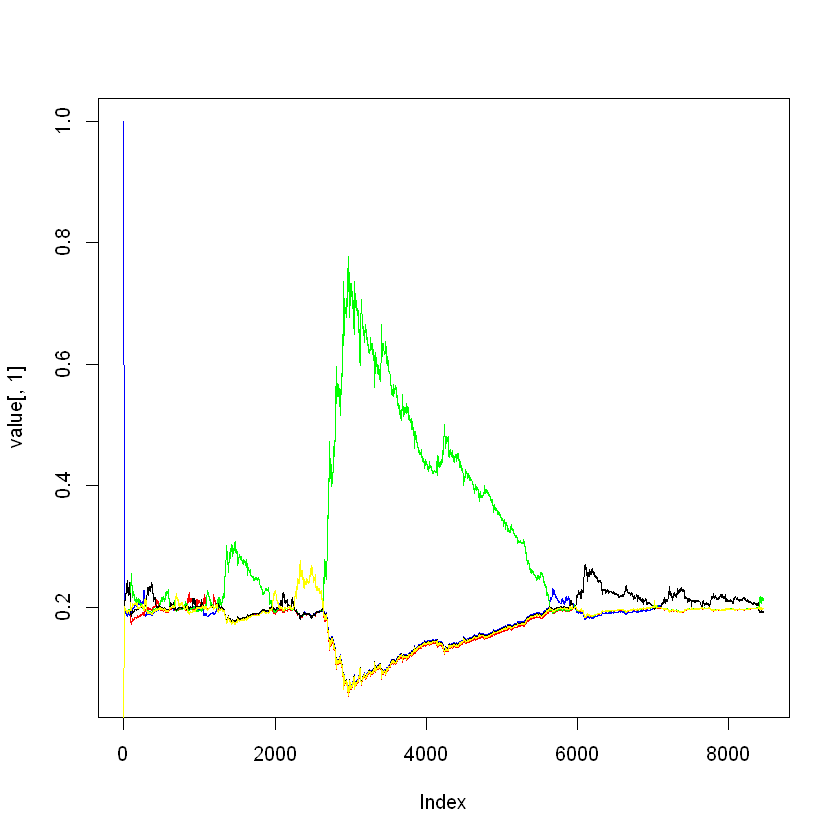

In [95]:
plot_graph <- function(run,arg){
    value <- run[[arg]]
    plot(value[,1],type="l",col="blue")
    lines(value[,2],type="l",col = "red")
    lines(value[,3],type="l",col = "green")
    lines(value[,4],type="l",col = "black")
    lines(value[,5],type="l",col = "yellow")
}

plot_graph(test.run,"actions")

In [77]:
test.run <- simulate_contextual1(5,nrow(close),0.8,10,0.8)

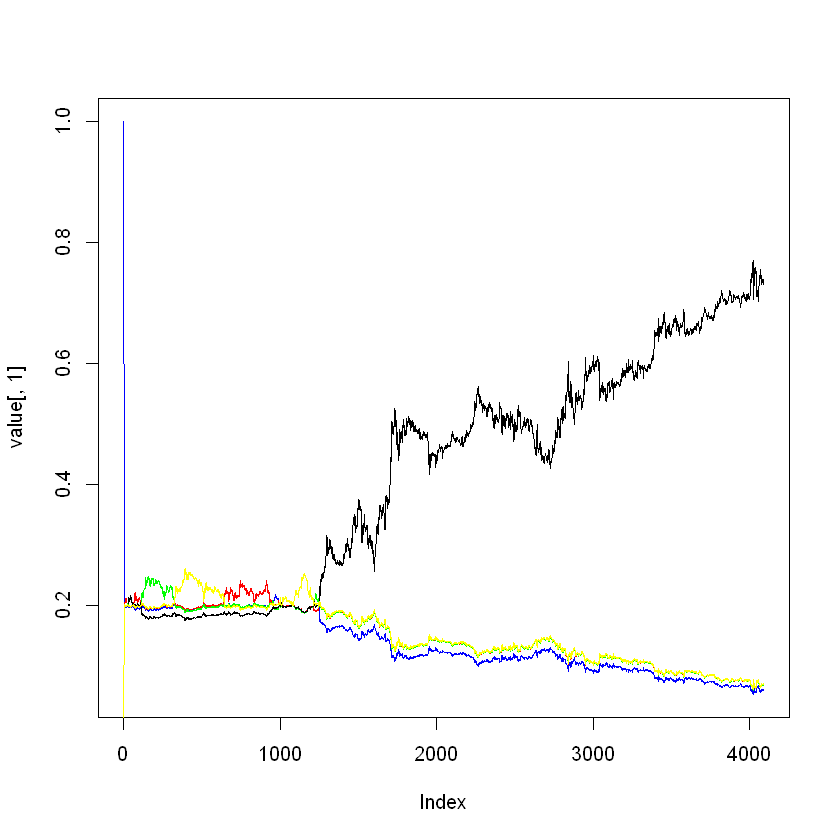

In [78]:
plot_graph(test.run,"actions")

In [101]:
# simulates contextual bandits problem
# This time action preferences are updated as if we pull all bandits and each timestep
# This is because we have full information of the environment
# params
# n_curren: number of currencies in proble (including cash)
# n_steps: number of timesteps in the episode
# alpha: learning rate of the action preference functions
# window_size: size of rolling window of asset prices to consider in the action preferences
# discount: discount factor of previous price changes
simulate_contextual2 <- function(n_curren,n_steps,alpha,window_size,discount){
  Ht <- rep(0,5) # initialize preference vector
  # initialize matrices
  piMat <- matrix(c(1,0,0,0,0),nrow=1,byrow=T)
  hMat <- matrix(Ht,nrow=1,byrow=T)
  yMat <- matrix(rep(0,n_curren),nrow=1,byrow=T)
  # Initialize weight vector for moving average window
  weight_vec <- c()
  for(k in 0:(window_size-1))
    weight_vec <- c(weight_vec,discount^k)
  weight_vec <- rev(weight_vec)
  
  price <- head(close,window_size+1) # initializes the price dataframe as the first 2 price vectors
  
  # history vector of price changes
  history <- getPriceRelativeVec(price[1,],price[2,])
  for(h in 2:window_size){
    history <- rbind(history,getPriceRelativeVec(price[h,],price[h+1,]))
  }
  
  # Define state st as vector of discounted previous relative changes
  st <- weight_vec %*% history
  
  prev_v <- tail(price,1) # initializes first price vector v
  
  # Define reward vecs and random action reward vectors
  Rvec <- c()
  Rvec_random <- c()
  Rvec_market <- c()
  market_average <- rep(1/5,5)
  R_all <- c(0)

  for(i in window_size:n_steps){
    # get price dataframe of current time step
    price <- head(close,i+2)
    # get the current v
    curr_v <- tail(price,1)
    # get price change
    yt <- getPriceRelativeVec(prev_v,curr_v)
    
    # update history matrix
    history <- rbind(tail(history,window_size-1),yt)
    
    # preference vector for state s (element-wise multiplication of Ht and st)
    Ht_s <- st * Ht
    
    # Compute pivec (softmaxes for each currency)
   
    piVec <- c()
    for(a in 1:n_curren)
      piVec <- c(piVec,get_softmax(a,Ht_s))
    
    # get the log returns for our action (in this case our action is the softax)
    rt <- exp(getLogReturns(yt,piVec))
    Rvec <- c(Rvec,rt)
    
    # get the log returns for pulling each arm
    Rvec_bandits <- c()
    for(a in 1:n_curren)
      Rvec_bandits <- c(Rvec_bandits,log(yt[a]))
    
    # update preference vector
    Ht <- get_update_all_bandits(Rvec_bandits,R_all,Ht,alpha)
    
    # check if we are at first timestep, and if so, initialize Rmat, else append to Rmat
#     if(i == window_size)
#       Rmat <-  matrix(Rvec_bandits,nrow=1,ncol=n_curren)
#     else
#       Rmat <- rbind(Rmat,Rvec_bandits)
      
    # check if we are at first timestep, and if so, initialize R_all vector, else append to vector
    if(i == window_size)
        R_all <-  Rvec_bandits
    else
        R_all <- c(R_all,Rvec_bandits)
      
    # Append to R_all vector
    R_all <- c(R_all,Rvec_bandits)
      
    # Reward for random action
    Rvec_random <- c(Rvec_random,exp(getLogReturns(yt,random_action(4))))
    
    # Reward for market average
    Rvec_market <- c(Rvec_market,exp(getLogReturns(yt,market_average)))
    
    # update prevsous price and state
    prev_v <- curr_v
    st <- weight_vec %*% history
    # append to matrices
    piMat <- rbind(piMat,piVec)
    hMat <- rbind(hMat,Ht)
    yMat <- rbind(yMat,yt)

  }
 
  return_list <- list(prod(Rvec),prod(Rvec_market),piMat,hMat,yMat, cumprod(Rvec),cumprod(Rvec_market))
  names(return_list) <- c("AgentRt","mktAve","actions","prefs","changes","AgentVec","MktVec")

  return(return_list)
}

In [96]:
c(c(1,2,3),c(4,5,6))

[1] 1 2 3 4 5 6

In [102]:
ctxt2 <- simulate_contextual2(5,nrow(close),0.05,10,0.8)

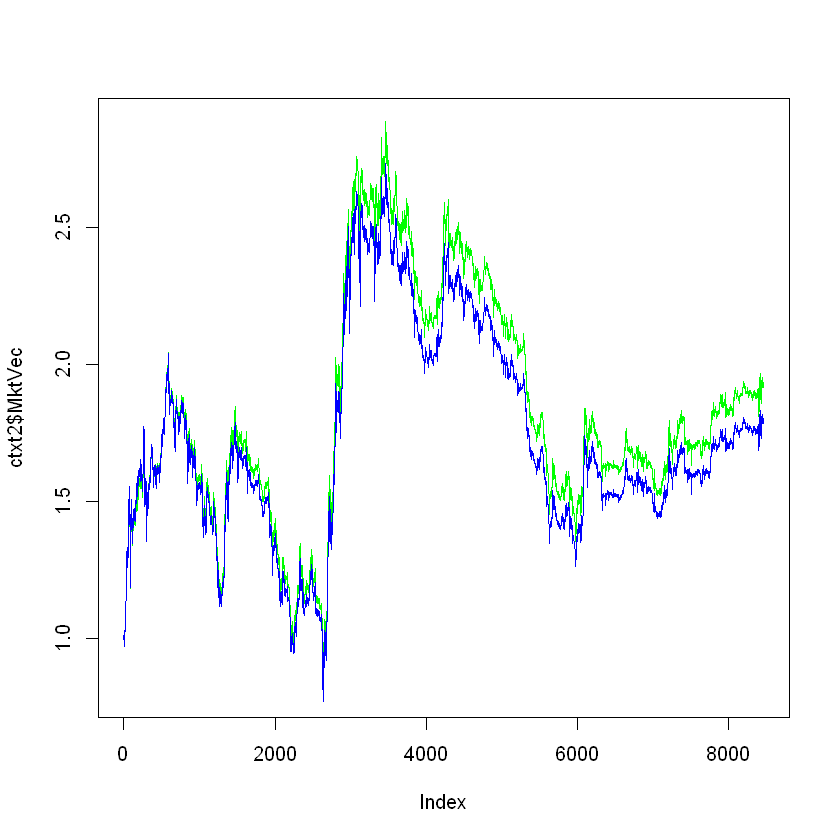

In [103]:
plot(ctxt2$MktVec,type="l",col="green")
lines(ctxt2$AgentVec,type="l",col="blue")

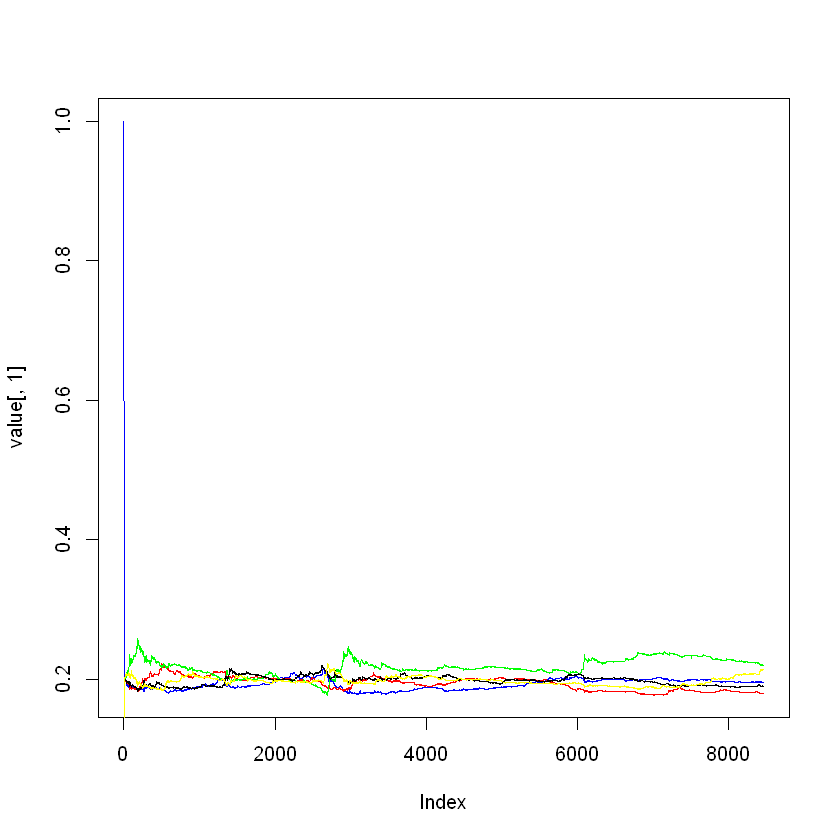

In [104]:
plot_graph(ctxt2,"actions")

In [46]:
# simulates contextual bandits problem strategy 3
# This is the all-in method, at each step we put all our assets into one cryptocrreuncy, effectively 
# making this a contextual k-armed bandits problem where we pull one arm and one arm only
# params
# n_curren: number of currencies in proble (including cash)
# n_steps: number of timesteps in the episode
# alpha: learning rate of the action preference functions
# window_size: size of rolling window of asset prices to consider in the action preferences
# discount: discount factor of previous price changes
# epsilon: epsilon value for epsilon greedy
simulate_contextual3 <- function(n_curren,n_steps,alpha,window_size,discount,epsilon=0.5){
    
    Ht <- rep(0,5) # initialize preference vector
    
    # Initialize weight vector for moving average window
    weight_vec <- c()
    for(k in 0:(window_size-1))
        weight_vec <- c(weight_vec,discount^k)
    weight_vec <- rev(weight_vec)
    
    price <- head(close,window_size+1) # initializes the price dataframe as the first 2 price vectors
    #st <- getPriceRelativeVec(price[1,],price[2,]) # get first price relative vector (first state)
    
    # history vector of price changes
    history <- getPriceRelativeVec(price[1,],price[2,])
    for(h in 2:window_size){
        history <- rbind(history,getPriceRelativeVec(price[h,],price[h+1,]))
    }
    
    # Define state st as vector of discounted previous relative changes
    st <- weight_vec %*% history
    
    prev_v <- tail(price,1) # initializes first price vector v
    
    # Define reward vecs and random action reward vectors
    Rvec <- c()
    Rvec_random <- c()
    Rvec_market <- c()
    market_average <- rep(1/5,5)
    
    # initialize matrices
    piMat <- matrix(c(1,0,0,0,0),nrow=1,byrow=T)
    hMat <- matrix(Ht,nrow=1,byrow=T)
    yMat <- matrix(rep(0,n_curren),nrow=1,byrow=T)
    aMat <- matrix(c(1,0,0,0,0),nrow=1,byrow=T)
    
    for(i in window_size:n_steps){
        # get price dataframe of current time step
        price <- head(close,i+2)
        # get the current v
        curr_v <- tail(price,1)
        # get price change
        yt <- getPriceRelativeVec(prev_v,curr_v)
        
        # update history matrix
        history <- rbind(tail(history,window_size-1),yt)
        
        # preference vector for state s (element-wise multiplication of Ht and st)
        Ht_s <- st * Ht
        
        # Compute pivec (softmaxes for each currency)
        piVec <- c()
        for(a in 1:n_curren)
            piVec <- c(piVec,get_softmax(a,Ht_s))
        
        if(runif(1) < epsilon)
            # do random action
            action <- sample(seq(1,n_curren),1)
        else
            # get the prefered action
            action <- which.max(piVec)
        
        # define action vec (1 if action is argmax of softmax)
        action_vec <- rep(0,n_curren)
        action_vec[action] <- 1
        
        # get the log returns for our action (in this case our action is the argmax over a)
        rt <- exp(getLogReturns(yt,action_vec))
        Rvec <- c(Rvec,rt)
        
        # Reward for random action
        Rvec_random <- c(Rvec_random,exp(getLogReturns(yt,random_action(4))))
        
        # Reward for market average
        Rvec_market <- c(Rvec_market,exp(getLogReturns(yt,market_average)))
        
        # Update preference vector
        Ht <- get_update(rt,Rvec,Ht,action,alpha)
        
#         print(log(yt))
#         print(Ht)
#         print(piVec)
#         print("=========================================")
        
#         print(paste0("episode",i))
#         print(cat("Ht: ", Ht))
#         print(cat("Ht_s: ", Ht_s))
        # print(cat("piVec: ", piVec))
#         print(cat("rt: ", rt))
        # print("==============================")
        
        prev_v <- curr_v
        st <- weight_vec %*% history
        
        # append to matrices
        piMat <- rbind(piMat,piVec)
        hMat <- rbind(hMat,Ht)
        yMat <- rbind(yMat,yt)
        aMat <- rbind(aMat,action_vec)
            
    }
    
    # create returrn list
    return_list <- list(prod(Rvec),prod(Rvec_market),piMat,hMat,yMat,cumprod(Rvec),cumprod(Rvec_market),aMat)
    names(return_list) <- c("AgentRt","mktAve","softmax","prefs","changes","AgentVec","mktVec","actions")
    
    return(return_list)
    
}

In [79]:
ctxt3 <- simulate_contextual3(5,nrow(close),0.8,10,0.8,0.2)

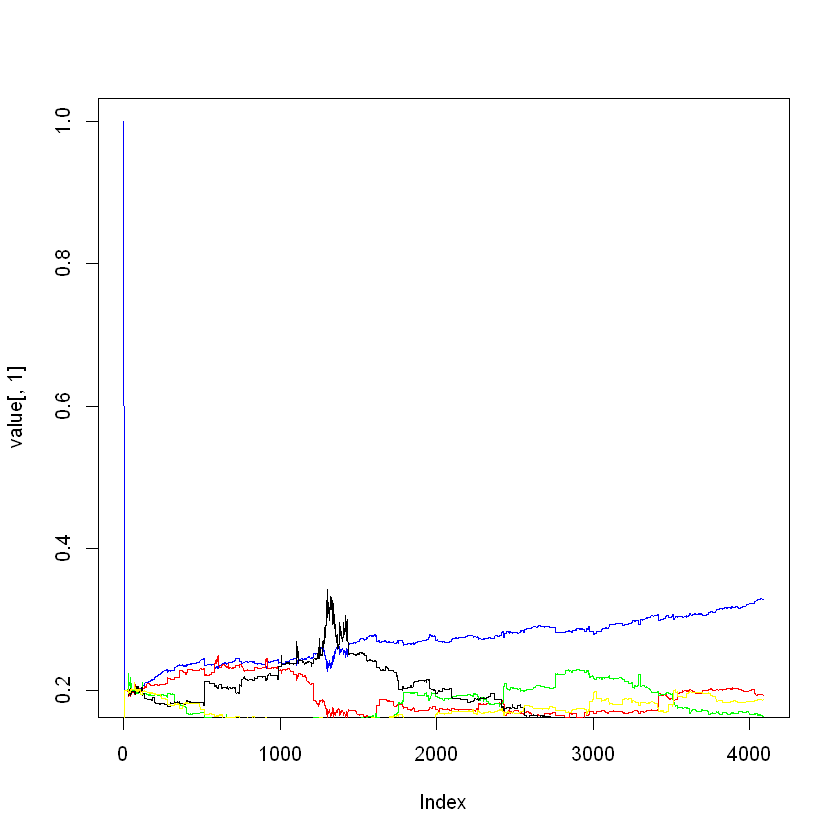

In [80]:
plot_graph(ctxt3,"softmax")

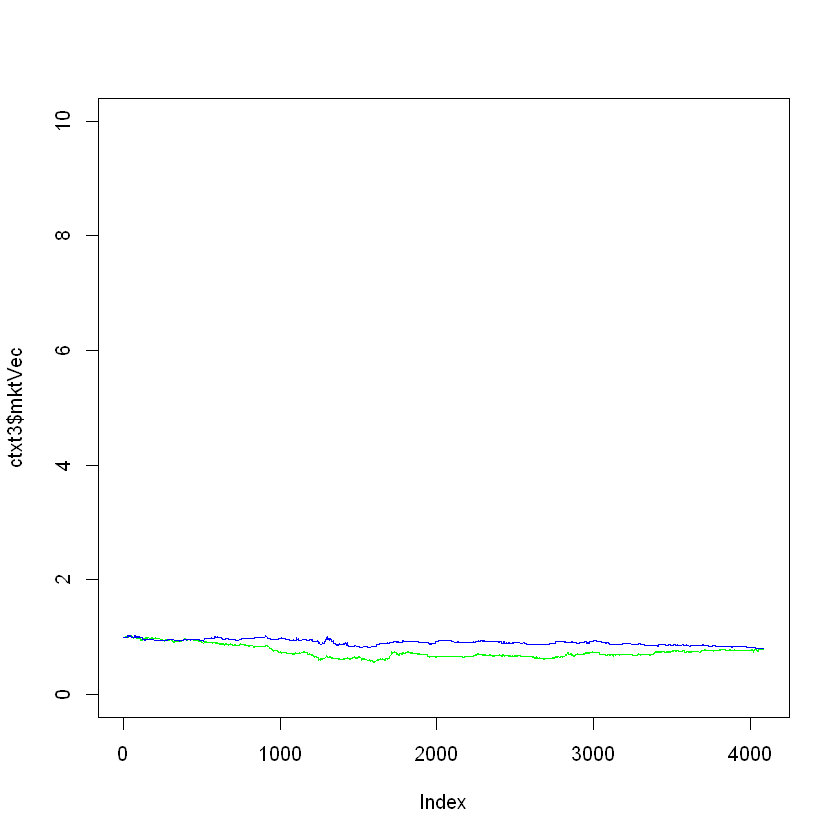

In [81]:
plot(ctxt3$mktVec,type="l",col="green",ylim = c(0,10))
lines(ctxt3$AgentVec,type="l",col="blue")

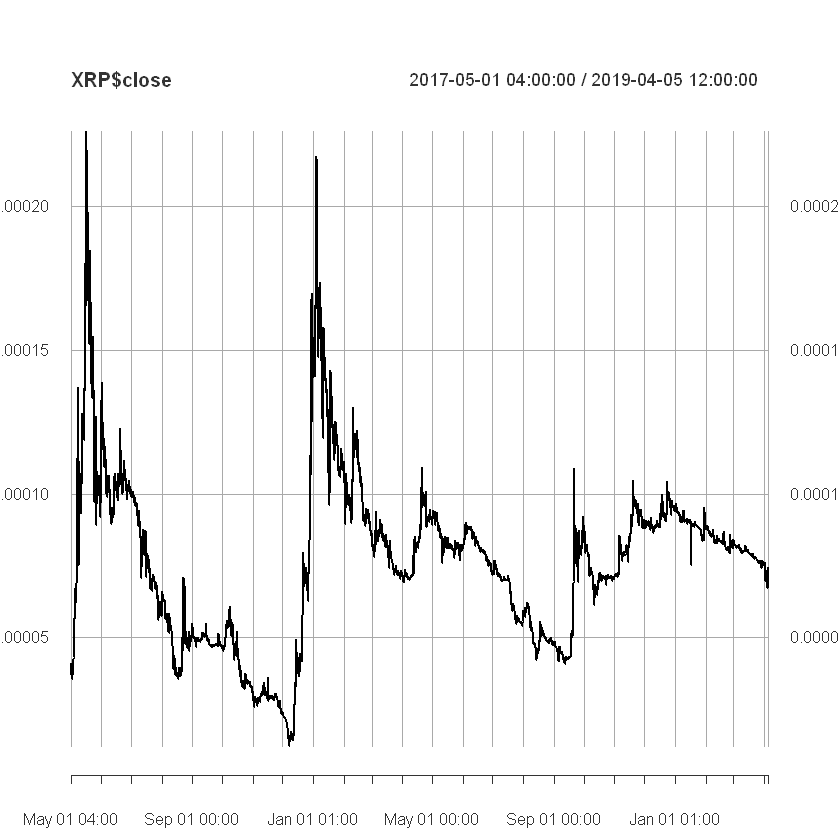

In [156]:
plot(XRP$close)